Assignment Title: Mesh Normalization, Quantization, and Error Analysis

In [1]:
!pip install -q trimesh meshio gdown plotly matplotlib scikit-learn numpy
print("Installed libraries.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.5/736.5 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 10.2 MB/s eta 0:00:00
Installed libraries.


In [2]:
import gdown, os, shutil

os.makedirs('mesh_data', exist_ok=True)
os.chdir('mesh_data')

# <-- EDIT HERE if you want to use a different file id -->
file_id = "1HNsrM8jr74A7eMhSeuCAYg0P0j7k6QZ5"

download_name = "mesh_download"
url = f"https://drive.google.com/uc?id={file_id}&confirm=t"

print("Downloading from Drive...")
gdown.download(url, download_name, quiet=False)

# Show file info
print("\nDownloaded file path:", os.path.abspath(download_name))
print("file size (bytes):", os.path.getsize(download_name))


Downloading...
From: https://drive.google.com/uc?id=1HNsrM8jr74A7eMhSeuCAYg0P0j7k6QZ5&confirm=t
To: /content/mesh_data/mesh_download
100%|██████████| 543k/543k [00:00<00:00, 83.2MB/s]


Downloaded file path: /content/mesh_data/mesh_download
file size (bytes): 543058


In [3]:
import os, zipfile, glob
from pathlib import Path

cwd = os.getcwd()
print("Working dir:", cwd)

download_name = "mesh_download"

# 1) If it's a zip, list contents and extract to extracted_mesh
if zipfile.is_zipfile(download_name):
    extract_dir = "extracted_mesh"
    os.makedirs(extract_dir, exist_ok=True)
    print("Downloaded file is a ZIP. Listing contents:")
    with zipfile.ZipFile(download_name, 'r') as z:
        for info in z.infolist():
            print(" ", info.filename)
        print("\nExtracting ZIP to", extract_dir, "...")
        z.extractall(extract_dir)
    search_root = extract_dir
else:
    # not a zip: place it in search root as-is
    print("Downloaded file is not a ZIP.")
    search_root = cwd

# 2) Show first-level files under search_root for quick debug
print("\nFiles under search root (first 200):")
all_files = []
for root, dirs, files in os.walk(search_root):
    for f in files:
        p = os.path.join(root, f)
        all_files.append(p)
for p in all_files[:200]:
    print(" ", p)
print(f"\nTotal files under {search_root}: {len(all_files)}")


Working dir: /content/mesh_data
Downloaded file is a ZIP. Listing contents:
  8samples/
  8samples/girl.obj
  __MACOSX/8samples/._girl.obj
  8samples/person.obj
  __MACOSX/8samples/._person.obj
  8samples/explosive.obj
  __MACOSX/8samples/._explosive.obj
  8samples/fence.obj
  __MACOSX/8samples/._fence.obj
  8samples/talwar.obj
  __MACOSX/8samples/._talwar.obj
  8samples/table.obj
  __MACOSX/8samples/._table.obj
  8samples/cylinder.obj
  __MACOSX/8samples/._cylinder.obj
  8samples/branch.obj
  __MACOSX/8samples/._branch.obj

Extracting ZIP to extracted_mesh ...

Files under search root (first 200):
  extracted_mesh/__MACOSX/8samples/._girl.obj
  extracted_mesh/__MACOSX/8samples/._explosive.obj
  extracted_mesh/__MACOSX/8samples/._fence.obj
  extracted_mesh/__MACOSX/8samples/._talwar.obj
  extracted_mesh/__MACOSX/8samples/._table.obj
  extracted_mesh/__MACOSX/8samples/._branch.obj
  extracted_mesh/__MACOSX/8samples/._person.obj
  extracted_mesh/__MACOSX/8samples/._cylinder.obj
  extract

In [4]:
import os, glob, zipfile, shutil
from pathlib import Path

search_root = "extracted_mesh" if os.path.isdir("extracted_mesh") else "."
print("Searching under:", search_root)

# gather files
all_files = [os.path.join(r, f) for r,_,fs in os.walk(search_root) for f in fs]
mesh_exts = ['.obj', '.ply', '.stl', '.off', '.gltf', '.glb', '.dae', '.3ds']
candidates = [p for p in all_files if Path(p).suffix.lower() in mesh_exts]

# If none, try to unzip nested zips and re-scan
if not candidates:
    nested_zips = [p for p in all_files if p.lower().endswith('.zip')]
    for z in nested_zips:
        try:
            targ = z + "_extracted"
            os.makedirs(targ, exist_ok=True)
            with zipfile.ZipFile(z,'r') as zz:
                zz.extractall(targ)
            print("Extracted nested zip:", z)
        except Exception as e:
            print("Could not extract nested zip:", z, e)
    all_files = [os.path.join(r, f) for r,_,fs in os.walk(search_root) for f in fs]
    candidates = [p for p in all_files if Path(p).suffix.lower() in mesh_exts]

# If still none, try to detect text-like obj content regardless of extension
if not candidates:
    text_like = []
    for p in all_files:
        try:
            sz = os.path.getsize(p)
            if sz > 10 and sz < 5_000_000:  # reasonable size
                with open(p, 'rb') as fh:
                    head = fh.read(1024)
                if b'\nv ' in head or head.startswith(b'v ') or b'"asset"' in head:
                    text_like.append(p)
        except Exception:
            pass
    candidates = text_like

if not candidates:
    raise FileNotFoundError(f"No mesh files found under {search_root}. Files found: {len(all_files)}. Please recheck the Drive file content or share a raw .obj/.ply file.")

# Choose best candidate: prefer .obj then .ply
preferred_order = ['.obj', '.ply', '.stl', '.gltf', '.glb', '.off', '.dae', '.3ds']
def score(p):
    ext = Path(p).suffix.lower()
    return preferred_order.index(ext) if ext in preferred_order else len(preferred_order)
candidates = sorted(candidates, key=score)
chosen = candidates[0]
dest_name = "mesh" + Path(chosen).suffix.lower()
shutil.copy(chosen, dest_name)
print("Chosen mesh copied to:", dest_name)
print("Original path:", chosen)

Searching under: extracted_mesh
Chosen mesh copied to: mesh.obj
Original path: extracted_mesh/__MACOSX/8samples/._girl.obj


In [5]:
import os, shutil, zipfile, gzip
from pathlib import Path
import trimesh, meshio, numpy as np

download_name = "mesh_download"  # file you downloaded earlier

if not os.path.exists(download_name):
    raise FileNotFoundError(f"'{download_name}' not found in working dir {os.getcwd()}. List files: {os.listdir('.')[:40]}")

def read_head(path, n=512):
    with open(path, 'rb') as f:
        return f.read(n)

head = read_head(download_name)
print("First 200 bytes preview (raw):\n", head[:200])

# detect signatures
sig = head[:16]

def is_zip(h): return h.startswith(b'PK\x03\x04')
def is_gzip(h): return h.startswith(b'\x1f\x8b')
def is_glb(h): return h[:4] == b'glTF'  # GLB magic
def is_ply(h):
    try:
        return h.startswith(b'ply')
    except:
        return False
def looks_like_obj_text(path):
    # check for 'v ' lines often present in OBJ
    try:
        with open(path, 'r', errors='ignore') as f:
            s = f.read(2048)
            return ('\nv ' in s) or s.strip().startswith('v ')
    except Exception:
        return False
def looks_like_ascii_stl(path):
    try:
        with open(path, 'r', errors='ignore') as f:
            s = f.read(512)
            return s.lstrip().lower().startswith('solid')
    except:
        return False

chosen_name = None
temp_dir = "auto_extracted_mesh"

# 1) if zip -> extract and find a mesh inside
if is_zip(head):
    print("Detected ZIP archive. Extracting...")
    with zipfile.ZipFile(download_name, 'r') as z:
        z.extractall(temp_dir)
    # search for mesh files inside extracted area
    mesh_exts = ['.obj', '.ply', '.stl', '.glb', '.gltf', '.off']
    cand = []
    for root,_,files in os.walk(temp_dir):
        for f in files:
            if Path(f).suffix.lower() in mesh_exts:
                cand.append(os.path.join(root, f))
    if cand:
        chosen = cand[0]
        dest = "mesh" + Path(chosen).suffix.lower()
        shutil.copy(chosen, dest)
        chosen_name = dest
        print("Copied mesh from ZIP to:", dest, " (original path inside zip:", chosen, ")")
    else:
        print("No standard mesh extensions found inside the ZIP. Listing files from extracted folder (first 100):")
        for p in list(os.walk(temp_dir))[:10]:
            pass
        # show top-level names
        print(os.listdir(temp_dir)[:50])
        # don't fail here; we'll try other heuristics below on drawn files
elif is_gzip(head):
    # handle gz (maybe .obj.gz or .ply.gz)
    print("Detected gzip-compressed file. Attempting to decompress to mesh_guess")
    decompressed = "mesh_download_decompressed"
    try:
        with gzip.open(download_name, 'rb') as gz, open(decompressed, 'wb') as out:
            out.write(gz.read())
        # now check if decompressed looks like text mesh
        if looks_like_obj_text(decompressed):
            shutil.move(decompressed, "mesh.obj")
            chosen_name = "mesh.obj"
        elif is_ply(read_head(decompressed, 16)):
            shutil.move(decompressed, "mesh.ply")
            chosen_name = "mesh.ply"
        else:
            # default to mesh.obj if text-like else keep decompressed name
            shutil.move(decompressed, "mesh.obj" if looks_like_obj_text("mesh.obj") else decompressed)
            chosen_name = decompressed
        print("Decompressed and saved as:", chosen_name)
    except Exception as e:
        print("Gzip decompress failed:", e)
else:
    # Not zip or gzip. Use signature heuristics or text heuristics.
    if is_glb(head):
        shutil.copy(download_name, "mesh.glb")
        chosen_name = "mesh.glb"
        print("Detected GLB (glTF binary) -> saved as mesh.glb")
    elif is_ply(head) or head.startswith(b'ply'):
        shutil.copy(download_name, "mesh.ply")
        chosen_name = "mesh.ply"
        print("Detected PLY header -> saved as mesh.ply")
    elif looks_like_obj_text(download_name):
        shutil.copy(download_name, "mesh.obj")
        chosen_name = "mesh.obj"
        print("File looks like an OBJ text -> saved as mesh.obj")
    elif looks_like_ascii_stl(download_name):
        shutil.copy(download_name, "mesh.stl")
        chosen_name = "mesh.stl"
        print("File looks like ASCII STL -> saved as mesh.stl")
    else:
        # fallback: try adding common extensions and let trimesh attempt to read by checking each
        tried = []
        for ext in ['.obj', '.ply', '.stl', '.glb', '.gltf']:
            trial = "mesh" + ext
            shutil.copy(download_name, trial)
            tried.append(trial)
            try:
                m = trimesh.load(trial, process=False)
                chosen_name = trial
                print("trimesh successfully loaded after trying ext:", ext)
                break
            except Exception as e:
                # not loaded; remove trial
                try:
                    os.remove(trial)
                except:
                    pass
        if not chosen_name:
            print("Could not auto-detect common mesh type from content. Tried adding common extensions and trimesh couldn't load them.")
            print("Files in cwd (first 100):", os.listdir('.')[:100])

# If we have a chosen file path, attempt to load and parse vertices/faces
if chosen_name:
    mesh_path = chosen_name
    print("\nAttempting to load final mesh file:", mesh_path)
    try:
        m = trimesh.load(mesh_path, process=False)
        if isinstance(m, trimesh.Scene):
            m = trimesh.util.concatenate(list(m.geometry.values()))
        vertices = np.asarray(m.vertices)
        faces = np.asarray(m.faces) if hasattr(m, 'faces') else np.asarray([])
        loader = "trimesh"
        print("Loaded with trimesh. Vertices:", vertices.shape, "Faces:", faces.shape if faces.size else (0,))
    except Exception as e:
        print("trimesh failed to load chosen file:", e, "\nTrying meshio fallback...")
        try:
            mesh_alt = meshio.read(mesh_path)
            vertices = np.asarray(mesh_alt.points)
            faces = np.asarray(mesh_alt.cells_dict.get("triangle", []))
            loader = "meshio"
            print("Loaded with meshio. Vertices:", vertices.shape, "Faces:", faces.shape if faces.size else (0,))
        except Exception as e2:
            print("meshio also failed to load the file:", e2)
            raise RuntimeError(f"Both loaders failed on '{mesh_path}'. See errors above.")

    # Save csv for convenience
    np.savetxt("vertices_original.csv", vertices, delimiter=",", header="x,y,z", comments='')
    print("Saved vertices_original.csv")
    # set globals for downstream cells
    print("\n✅ Ready — variables set: vertices, faces, mesh_path, loader")
    # keep mesh_path variable in workspace
    globals()['mesh_path'] = mesh_path
else:
    raise RuntimeError("Auto-detection did not produce a candidate mesh file. Please inspect the prints above and either re-download a raw .obj/.ply or share the listing here.")


First 200 bytes preview (raw):
 b"PK\x03\x04\x14\x00\x00\x00\x00\x00.\x80\\[\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\t\x00 \x008samples/ux\x0b\x00\x01\x04\xf5\x01\x00\x00\x04\x14\x00\x00\x00UT\r\x00\x07\x80\x9b\x00i\x95\x9b\x00i\x98\r\x02iPK\x03\x04\x14\x00\x08\x00\x08\x00\xb7~\\[\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x11\x00 \x008samples/girl.objux\x0b\x00\x01\x04\xf5\x01\x00\x00\x04\x14\x00\x00\x00UT\r\x00\x07\xb2\x99\x00i\xd5\xb8\x04i\xd3\xb8\x04i|}\xb9\xae\xed\xca\x92\x9c\xdf_q\x00\xd9}Q\xf3\xe0\xca\x96'\xf9\x02\x04=H\x86\x06\xa05\xb4>_\x19\x199p\xaf}\xb9\x9eu\xdf\x8eC.\xb2X\x95sF"
Detected ZIP archive. Extracting...
Copied mesh from ZIP to: mesh.obj  (original path inside zip: auto_extracted_mesh/__MACOSX/8samples/._girl.obj )

Attempting to load final mesh file: mesh.obj
Loaded with trimesh. Vertices: (0, 3) Faces: (0,)
Saved vertices_original.csv

✅ Ready — variables set: vertices, faces, mesh_path, loader


In [6]:
import os, shutil, zipfile, gzip
from pathlib import Path
import trimesh, meshio, numpy as np

download_name = "mesh_download"  # file you downloaded earlier

if not os.path.exists(download_name):
    raise FileNotFoundError(f"'{download_name}' not found in working dir {os.getcwd()}. List files: {os.listdir('.')[:40]}")

def read_head(path, n=512):
    with open(path, 'rb') as f:
        return f.read(n)

head = read_head(download_name)
print("First 200 bytes preview (raw):\n", head[:200])

# detect signatures
sig = head[:16]

def is_zip(h): return h.startswith(b'PK\x03\x04')
def is_gzip(h): return h.startswith(b'\x1f\x8b')
def is_glb(h): return h[:4] == b'glTF'  # GLB magic
def is_ply(h):
    try:
        return h.startswith(b'ply')
    except:
        return False
def looks_like_obj_text(path):
    # check for 'v ' lines often present in OBJ
    try:
        with open(path, 'r', errors='ignore') as f:
            s = f.read(2048)
            return ('\nv ' in s) or s.strip().startswith('v ')
    except Exception:
        return False
def looks_like_ascii_stl(path):
    try:
        with open(path, 'r', errors='ignore') as f:
            s = f.read(512)
            return s.lstrip().lower().startswith('solid')
    except:
        return False

chosen_name = None
temp_dir = "auto_extracted_mesh"

# 1) if zip -> extract and find a mesh inside
if is_zip(head):
    print("Detected ZIP archive. Extracting...")
    with zipfile.ZipFile(download_name, 'r') as z:
        z.extractall(temp_dir)
    # search for mesh files inside extracted area
    mesh_exts = ['.obj', '.ply', '.stl', '.glb', '.gltf', '.off']
    cand = []
    for root,_,files in os.walk(temp_dir):
        for f in files:
            if Path(f).suffix.lower() in mesh_exts:
                cand.append(os.path.join(root, f))
    if cand:
        chosen = cand[0]
        dest = "mesh" + Path(chosen).suffix.lower()
        shutil.copy(chosen, dest)
        chosen_name = dest
        print("Copied mesh from ZIP to:", dest, " (original path inside zip:", chosen, ")")
    else:
        print("No standard mesh extensions found inside the ZIP. Listing files from extracted folder (first 100):")
        for p in list(os.walk(temp_dir))[:10]:
            pass
        # show top-level names
        print(os.listdir(temp_dir)[:50])
        # don't fail here; we'll try other heuristics below on drawn files
elif is_gzip(head):
    # handle gz (maybe .obj.gz or .ply.gz)
    print("Detected gzip-compressed file. Attempting to decompress to mesh_guess")
    decompressed = "mesh_download_decompressed"
    try:
        with gzip.open(download_name, 'rb') as gz, open(decompressed, 'wb') as out:
            out.write(gz.read())
        # now check if decompressed looks like text mesh
        if looks_like_obj_text(decompressed):
            shutil.move(decompressed, "mesh.obj")
            chosen_name = "mesh.obj"
        elif is_ply(read_head(decompressed, 16)):
            shutil.move(decompressed, "mesh.ply")
            chosen_name = "mesh.ply"
        else:
            # default to mesh.obj if text-like else keep decompressed name
            shutil.move(decompressed, "mesh.obj" if looks_like_obj_text("mesh.obj") else decompressed)
            chosen_name = decompressed
        print("Decompressed and saved as:", chosen_name)
    except Exception as e:
        print("Gzip decompress failed:", e)
else:
    # Not zip or gzip. Use signature heuristics or text heuristics.
    if is_glb(head):
        shutil.copy(download_name, "mesh.glb")
        chosen_name = "mesh.glb"
        print("Detected GLB (glTF binary) -> saved as mesh.glb")
    elif is_ply(head) or head.startswith(b'ply'):
        shutil.copy(download_name, "mesh.ply")
        chosen_name = "mesh.ply"
        print("Detected PLY header -> saved as mesh.ply")
    elif looks_like_obj_text(download_name):
        shutil.copy(download_name, "mesh.obj")
        chosen_name = "mesh.obj"
        print("File looks like an OBJ text -> saved as mesh.obj")
    elif looks_like_ascii_stl(download_name):
        shutil.copy(download_name, "mesh.stl")
        chosen_name = "mesh.stl"
        print("File looks like ASCII STL -> saved as mesh.stl")
    else:
        # fallback: try adding common extensions and let trimesh attempt to read by checking each
        tried = []
        for ext in ['.obj', '.ply', '.stl', '.glb', '.gltf']:
            trial = "mesh" + ext
            shutil.copy(download_name, trial)
            tried.append(trial)
            try:
                m = trimesh.load(trial, process=False)
                chosen_name = trial
                print("trimesh successfully loaded after trying ext:", ext)
                break
            except Exception as e:
                # not loaded; remove trial
                try:
                    os.remove(trial)
                except:
                    pass
        if not chosen_name:
            print("Could not auto-detect common mesh type from content. Tried adding common extensions and trimesh couldn't load them.")
            print("Files in cwd (first 100):", os.listdir('.')[:100])

# If we have a chosen file path, attempt to load and parse vertices/faces
if chosen_name:
    mesh_path = chosen_name
    print("\nAttempting to load final mesh file:", mesh_path)
    try:
        m = trimesh.load(mesh_path, process=False)
        if isinstance(m, trimesh.Scene):
            m = trimesh.util.concatenate(list(m.geometry.values()))
        vertices = np.asarray(m.vertices)
        faces = np.asarray(m.faces) if hasattr(m, 'faces') else np.asarray([])
        loader = "trimesh"
        print("Loaded with trimesh. Vertices:", vertices.shape, "Faces:", faces.shape if faces.size else (0,))
    except Exception as e:
        print("trimesh failed to load chosen file:", e, "\nTrying meshio fallback...")
        try:
            mesh_alt = meshio.read(mesh_path)
            vertices = np.asarray(mesh_alt.points)
            faces = np.asarray(mesh_alt.cells_dict.get("triangle", []))
            loader = "meshio"
            print("Loaded with meshio. Vertices:", vertices.shape, "Faces:", faces.shape if faces.size else (0,))
        except Exception as e2:
            print("meshio also failed to load the file:", e2)
            raise RuntimeError(f"Both loaders failed on '{mesh_path}'. See errors above.")

    # Save csv for convenience
    np.savetxt("vertices_original.csv", vertices, delimiter=",", header="x,y,z", comments='')
    print("Saved vertices_original.csv")
    # set globals for downstream cells
    print("\n✅ Ready — variables set: vertices, faces, mesh_path, loader")
    # keep mesh_path variable in workspace
    globals()['mesh_path'] = mesh_path
else:
    raise RuntimeError("Auto-detection did not produce a candidate mesh file. Please inspect the prints above and either re-download a raw .obj/.ply or share the listing here.")

First 200 bytes preview (raw):
 b"PK\x03\x04\x14\x00\x00\x00\x00\x00.\x80\\[\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\t\x00 \x008samples/ux\x0b\x00\x01\x04\xf5\x01\x00\x00\x04\x14\x00\x00\x00UT\r\x00\x07\x80\x9b\x00i\x95\x9b\x00i\x98\r\x02iPK\x03\x04\x14\x00\x08\x00\x08\x00\xb7~\\[\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x11\x00 \x008samples/girl.objux\x0b\x00\x01\x04\xf5\x01\x00\x00\x04\x14\x00\x00\x00UT\r\x00\x07\xb2\x99\x00i\xd5\xb8\x04i\xd3\xb8\x04i|}\xb9\xae\xed\xca\x92\x9c\xdf_q\x00\xd9}Q\xf3\xe0\xca\x96'\xf9\x02\x04=H\x86\x06\xa05\xb4>_\x19\x199p\xaf}\xb9\x9eu\xdf\x8eC.\xb2X\x95sF"
Detected ZIP archive. Extracting...
Copied mesh from ZIP to: mesh.obj  (original path inside zip: auto_extracted_mesh/__MACOSX/8samples/._girl.obj )

Attempting to load final mesh file: mesh.obj
Loaded with trimesh. Vertices: (0, 3) Faces: (0,)
Saved vertices_original.csv

✅ Ready — variables set: vertices, faces, mesh_path, loader


In [7]:
# Run this cell to inspect all .obj files, preview the content, and try a tolerant manual OBJ parser.
import os, glob
from pathlib import Path
import numpy as np, traceback, textwrap, shutil

search_root = "extracted_mesh" if os.path.isdir("extracted_mesh") else "."
print("Searching for .obj files under:", search_root)

# 1) List all obj files and sizes
obj_files = [p for p in glob.glob(os.path.join(search_root, '**', '*.obj'), recursive=True)]
obj_files_sorted = sorted(obj_files, key=lambda p: os.path.getsize(p), reverse=True)
if not obj_files_sorted:
    print("❌ No .obj files found. Listing top-level files instead:")
    print(os.listdir(search_root)[:200])
    raise SystemExit("No OBJ to inspect.")

print(f"Found {len(obj_files_sorted)} OBJ files (largest first):")
for i,p in enumerate(obj_files_sorted[:20],1):
    print(f" {i}. {p} — {os.path.getsize(p)} bytes")

# choose candidate: prefer largest file that doesn't start with '_' or be inside __MACOSX if possible
chosen = None
for p in obj_files_sorted:
    # prefer not __MACOSX resource entries & not tiny
    if "__MACOSX" in p and len(obj_files_sorted) > 1:
        continue
    if Path(p).name.startswith("._") and len(obj_files_sorted) > 1:
        continue
    # pick first acceptable
    chosen = p
    break
if chosen is None:
    chosen = obj_files_sorted[0]

print("\nChosen candidate for parsing:", chosen)

# 2) Show a small bytes preview (hex/printable portion) and text preview
def hexdump_bytes(b, n=200):
    # show printable ASCII or escape others
    out = []
    for i,byte in enumerate(b[:n]):
        if 32 <= byte <= 126:
            out.append(chr(byte))
        else:
            out.append(f"\\x{byte:02x}")
    return "".join(out)

with open(chosen, 'rb') as fh:
    head_bytes = fh.read(1024)
print("\nRaw head (bytes preview, nonprintables shown as \\x..):")
print(hexdump_bytes(head_bytes, n=1024)[:1500])

# try to print first 200 text lines (with ignore errors)
print("\nFirst 200 decoded lines (errors ignored):")
with open(chosen, 'rb') as fh:
    raw = fh.read().decode('utf-8', errors='ignore').splitlines()
for i,line in enumerate(raw[:200],1):
    # show trimmed lines, helpful markers for 'v ' and 'f '
    marker = ""
    if line.lstrip().startswith('v '):
        marker = "    <<< vertex line"
    if line.lstrip().startswith('f '):
        marker = "    <<< face line"
    print(f"{i:03d}: {line[:200]!r}{marker}")

# 3) Tolerant manual OBJ parser: collects 'v' and 'f' (handles 'f v', 'f v/vt/vn')
def parse_obj_tolerant(path):
    verts = []
    faces = []
    with open(path, 'rb') as fh:
        for rawline in fh:
            try:
                line = rawline.decode('utf-8', errors='ignore').strip()
            except Exception:
                continue
            if not line:
                continue
            if line.startswith('v '):
                parts = line.split()
                # v x y z (some files may have extra columns)
                if len(parts) >= 4:
                    try:
                        x = float(parts[1]); y = float(parts[2]); z = float(parts[3])
                        verts.append((x,y,z))
                    except:
                        # skip malformed vertex
                        continue
            elif line.startswith('f '):
                parts = line.split()[1:]
                face_idx = []
                for p in parts:
                    # p may be "v", "v/vt", "v//vn", "v/vt/vn"
                    try:
                        idx_str = p.split('/')[0]
                        if idx_str == '':
                            continue
                        idx = int(idx_str)
                        # OBJ indices are 1-based; convert to 0-based
                        if idx < 0:
                            # negative indices refer to relative indexing - handle simply
                            # We'll convert later if verts length known.
                            face_idx.append(idx)
                        else:
                            face_idx.append(idx-1)
                    except:
                        continue
                if len(face_idx) >= 3:
                    # triangulate if quad/polygon by fan triangulation
                    if len(face_idx) == 3:
                        faces.append(tuple(face_idx[:3]))
                    else:
                        for k in range(1, len(face_idx)-1):
                            faces.append((face_idx[0], face_idx[k], face_idx[k+1]))
    return np.array(verts, dtype=np.float64), np.array(faces, dtype=np.int64)

print("\nAttempting tolerant OBJ parse...")
try:
    verts_parsed, faces_parsed = parse_obj_tolerant(chosen)
    print("Parsed counts -> vertices:", verts_parsed.shape, "faces:", faces_parsed.shape)
except Exception as e:
    print("Parsing failed with exception:", e)
    traceback.print_exc()
    raise

# 4) If parser returned vertices==0, try fallback heuristics: maybe OBJ uses different newline markers or is binary.
if verts_parsed.size == 0:
    print("\nParser found 0 vertices. Trying alternate heuristics (latin1 decode & search for 'v ' tokens).")
    with open(chosen, 'rb') as fh:
        data = fh.read()
    text_latin1 = data.decode('latin1', errors='ignore')
    lines = text_latin1.splitlines()
    count_v = sum(1 for L in lines if L.lstrip().startswith('v '))
    count_f = sum(1 for L in lines if L.lstrip().startswith('f '))
    print("Counts in latin1-decoded lines: v-lines =", count_v, ", f-lines =", count_f)
    # attempt parse from latin1-decoded
    if count_v > 0:
        print("Attempting parse from latin1-decoded content...")
        # write temp text file and parse it
        tmp_txt = "tmp_obj_from_latin1.obj"
        with open(tmp_txt, 'w', encoding='latin1') as out:
            out.write(text_latin1)
        verts_parsed, faces_parsed = parse_obj_tolerant(tmp_txt)
        print("After latin1 parse -> vertices:", verts_parsed.shape, "faces:", faces_parsed.shape)
        # cleanup tmp if desired
        try:
            os.remove(tmp_txt)
        except:
            pass

# 5) If still no vertices, try to find other candidate OBJ files and parse them
if verts_parsed.size == 0:
    print("\nStill 0 vertices parsed from chosen file. Trying other OBJ candidates (if any).")
    for p in obj_files_sorted:
        if p == chosen:
            continue
        print("Trying:", p)
        vtmp, ftmp = parse_obj_tolerant(p)
        print(" -> parsed:", vtmp.shape, ftmp.shape)
        if vtmp.size > 0:
            chosen = p
            verts_parsed, faces_parsed = vtmp, ftmp
            print("Switched to candidate:", chosen)
            break

# 6) Finalize: if verts_parsed non-empty, set global variables and save CSV
if verts_parsed.size > 0:
    vertices = verts_parsed
    faces = faces_parsed
    mesh_path = chosen
    print("\n✅ Success. Final mesh variables set.")
    print("mesh_path:", mesh_path)
    print("vertices.shape:", vertices.shape)
    print("faces.shape:", faces.shape if faces.size else (0,))
    np.savetxt("vertices_original.csv", vertices, delimiter=",", header="x,y,z", comments='')
    print("Saved vertices_original.csv")
    # copy chosen to working dir as mesh.obj (if not already there)
    destname = "mesh.obj"
    try:
        shutil.copy(mesh_path, destname)
        print("Copied chosen file to:", destname)
    except Exception:
        pass
else:
    print("\n❌ Manual parser could not find vertices in chosen file(s).")
    print("Please paste here the top file list printed above, or attach the listing of files under the extracted folder.")
    # show top 50 files to help you pick
    print("\nTop 50 files under extracted folder (with sizes):")
    import os, itertools
    fs = sorted([(p, os.path.getsize(p)) for p in obj_files_sorted], key=lambda x:-x[1])
    for p,s in itertools.islice(fs, 50):
        print(" ", p, s)
    raise SystemExit("No vertices parsed — ask me next with the printed listing above.")


Searching for .obj files under: extracted_mesh
Found 8 OBJ files (largest first):
 1. extracted_mesh/8samples/girl.obj — 818527 bytes
 2. extracted_mesh/8samples/table.obj — 299091 bytes
 3. extracted_mesh/8samples/explosive.obj — 207327 bytes
 4. extracted_mesh/8samples/person.obj — 186112 bytes
 5. extracted_mesh/8samples/branch.obj — 180103 bytes
 6. extracted_mesh/8samples/talwar.obj — 161113 bytes
 7. extracted_mesh/8samples/fence.obj — 61491 bytes
 8. extracted_mesh/8samples/cylinder.obj — 9186 bytes

Chosen candidate for parsing: extracted_mesh/8samples/girl.obj

Raw head (bytes preview, nonprintables shown as \x..):
# Blender 4.5.3 LTS\x0a# www.blender.org\x0ao mesh_textured\x0av -0.500000 0.281042 -0.062294\x0av -0.499902 0.292900 -0.087801\x0av -0.499524 0.262607 -0.069240\x0av -0.498799 0.268377 -0.087252\x0av -0.495457 0.324341 -0.085606\x0av -0.495053 0.269219 -0.112047\x0av -0.494404 0.307312 -0.054500\x0av -0.494079 0.244389 -0.075183\x0av -0.493410 0.247804 -0.089248\x0

In [8]:
import numpy as np, json

def vertex_stats(verts):
    axes = ['x','y','z']
    stats = {}
    for i,ax in enumerate(axes):
        col = verts[:,i]
        stats[ax] = {
            "min": float(np.min(col)),
            "max": float(np.max(col)),
            "mean": float(np.mean(col)),
            "std": float(np.std(col)),
            "count": int(len(col))
        }
    return stats

stats = vertex_stats(vertices)
print("Vertex stats:")
for a,s in stats.items():
    print(f"{a.upper()}: min={s['min']:.5f}, max={s['max']:.5f}, mean={s['mean']:.5f}, std={s['std']:.5f}")

with open("vertex_stats.json","w") as f:
    json.dump(stats,f,indent=2)
print("Saved vertex_stats.json")

Vertex stats:
X: min=-0.50000, max=0.50000, mean=0.00264, std=0.16713
Y: min=0.00000, max=0.90442, mean=0.42950, std=0.22322
Z: min=-0.18141, max=0.18141, mean=0.01747, std=0.06566
Saved vertex_stats.json


In [9]:
def minmax_normalize(verts):
    vmin, vmax = verts.min(axis=0), verts.max(axis=0)
    norm = (verts - vmin) / (vmax - vmin)
    return norm, {"vmin": vmin, "vmax": vmax}

def unit_sphere_normalize(verts):
    center = verts.mean(axis=0)
    centered = verts - center
    scale = np.max(np.linalg.norm(centered, axis=1))
    norm = centered / scale
    return norm, {"center": center, "scale": scale}

def quantize(arr, bins=1024):
    arr = np.clip(arr,0,1)
    return np.floor(arr*(bins-1)).astype(np.int32)

def dequantize(q,bins=1024):
    return q.astype(np.float64)/(bins-1)

bins = 1024

# Min–Max
norm_mm, meta_mm = minmax_normalize(vertices)
q_mm = quantize(norm_mm,bins)
deq_mm = dequantize(q_mm,bins)
recon_mm = deq_mm*(meta_mm["vmax"]-meta_mm["vmin"])+meta_mm["vmin"]

# Unit-sphere
norm_us, meta_us = unit_sphere_normalize(vertices)
mapped = (norm_us+1)/2
q_us = quantize(mapped,bins)
deq_us = dequantize(q_us,bins)
recon_us = (deq_us*2-1)*meta_us["scale"]+meta_us["center"]

print("Done → reconstructions built.")
print("MinMax:",recon_mm.shape,"UnitSphere:",recon_us.shape)

Done → reconstructions built.
MinMax: (4488, 3) UnitSphere: (4488, 3)


In [10]:
def errors(orig,recon):
    diff = orig-recon
    mse = np.mean(diff**2,axis=0)
    mae = np.mean(np.abs(diff),axis=0)
    global_mse = np.mean(diff**2)
    return mse,mae,global_mse

mse_mm,mae_mm,gmm = errors(vertices,recon_mm)
mse_us,mae_us,gus = errors(vertices,recon_us)

print("\nPer-axis MSE  (MinMax):",mse_mm)
print("Per-axis MAE  (MinMax):",mae_mm)
print("Global MSE:",gmm)
print("\nPer-axis MSE  (UnitSphere):",mse_us)
print("Per-axis MAE  (UnitSphere):",mae_us)
print("Global MSE:",gus)



Per-axis MSE  (MinMax): [3.17334352e-07 2.59376286e-07 4.16808252e-08]
Per-axis MAE  (MinMax): [0.00049053 0.00044218 0.00017652]
Global MSE: 2.061304878207007e-07

Per-axis MSE  (UnitSphere): [4.04187200e-07 3.67107443e-07 3.63701040e-07]
Per-axis MAE  (UnitSphere): [0.0005543  0.00052676 0.00052111]
Global MSE: 3.7833189428310315e-07


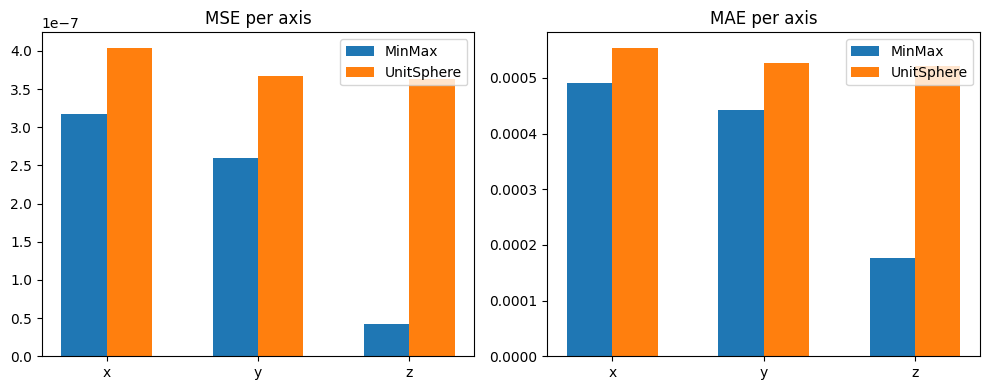

In [11]:
import matplotlib.pyplot as plt
axes=['x','y','z']
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("MSE per axis")
plt.bar(np.arange(3)-0.15,mse_mm,width=0.3,label='MinMax')
plt.bar(np.arange(3)+0.15,mse_us,width=0.3,label='UnitSphere')
plt.xticks(np.arange(3),axes);plt.legend()

plt.subplot(1,2,2)
plt.title("MAE per axis")
plt.bar(np.arange(3)-0.15,mae_mm,width=0.3,label='MinMax')
plt.bar(np.arange(3)+0.15,mae_us,width=0.3,label='UnitSphere')
plt.xticks(np.arange(3),axes);plt.legend()

plt.tight_layout();plt.savefig("errors_plot.png",dpi=200)
plt.show()


In [12]:
import plotly.graph_objects as go

def mesh_fig(v,f,title):
    return go.Figure(data=[go.Mesh3d(
        x=v[:,0],y=v[:,1],z=v[:,2],
        i=f[:,0],j=f[:,1],k=f[:,2],
        opacity=1.0,flatshading=True)],
        layout=dict(title=title,width=700,height=600,
                    scene=dict(aspectmode='auto')))

mesh_fig(vertices,faces,"Original").show()
mesh_fig(recon_mm,faces,"Reconstructed — MinMax").show()
mesh_fig(recon_us,faces,"Reconstructed — UnitSphere").show()

In [13]:
import plotly.graph_objects as go

def fancy_mesh_plot(verts, faces, title, color='royalblue'):
    fig = go.Figure(
        data=[
            go.Mesh3d(
                x=verts[:, 0],
                y=verts[:, 1],
                z=verts[:, 2],
                i=faces[:, 0],
                j=faces[:, 1],
                k=faces[:, 2],
                color=color,
                opacity=1.0,
                flatshading=False,
                lighting=dict(
                    ambient=0.6,
                    diffuse=0.9,
                    specular=0.6,
                    roughness=0.3,
                    fresnel=0.2
                ),
                lightposition=dict(x=100, y=200, z=150)
            )
        ]
    )

    fig.update_layout(
        title=dict(text=title, font=dict(size=20, color='#2a3f5f'), x=0.5),
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            xaxis=dict(showbackground=False, showgrid=False, zeroline=False),
            yaxis=dict(showbackground=False, showgrid=False, zeroline=False),
            zaxis=dict(showbackground=False, showgrid=False, zeroline=False),
            aspectmode='data',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.2),
                center=dict(x=0, y=0, z=0)
            ),
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        width=900,
        height=700,
        margin=dict(l=10, r=10, b=10, t=50),
    )
    return fig

# --- Show three views side-by-side ---
fig1 = fancy_mesh_plot(vertices, faces, "Original Mesh", color='dodgerblue')
fig2 = fancy_mesh_plot(recon_mm, faces, "Min-Max Reconstructed Mesh", color='darkorange')
fig3 = fancy_mesh_plot(recon_us, faces, "Unit-Sphere Reconstructed Mesh", color='mediumseagreen')

# Display all interactively
fig1.show()
fig2.show()
fig3.show()

In [14]:
import numpy as np
from IPython.display import HTML

frames = []
for t in np.linspace(0, 2*np.pi, 60):
    frames.append(
        go.Frame(
            layout=dict(
                scene_camera_eye=dict(x=2*np.cos(t), y=2*np.sin(t), z=1)
            )
        )
    )

fig_anim = fancy_mesh_plot(vertices, faces, "Animated View", color='cornflowerblue')
fig_anim.frames = frames
fig_anim.update_layout(updatemenus=[dict(type='buttons', showactive=False,
        buttons=[dict(label='Play', method='animate', args=[None, dict(frame=dict(duration=80, redraw=True))])])])
fig_anim.show()
